# Title- Titanic: Machine Learning from Disaster

### Competition Description

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

#### Practice Skills
###### Binary classification 
---

### Overview
The data has been split into two groups:

training set (train.csv)
test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

----

### Data Dictionary

<table>
<tbody>
<tr><th><b>Variable</b></th><th><b>Definition</b></th><th><b>Key</b></th></tr>
<tr>
<td>survival</td>
<td>Survival</td>
<td>0 = No, 1 = Yes</td>
</tr>
<tr>
<td>pclass</td>
<td>Ticket class</td>
<td>1 = 1st, 2 = 2nd, 3 = 3rd</td>
</tr>
<tr>
<td>sex</td>
<td>Sex</td>
<td></td>
</tr>
<tr>
<td>Age</td>
<td>Age in years</td>
<td></td>
</tr>
<tr>
<td>sibsp</td>
<td># of siblings / spouses aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>parch</td>
<td># of parents / children aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>ticket</td>
<td>Ticket number</td>
<td></td>
</tr>
<tr>
<td>fare</td>
<td>Passenger fare</td>
<td></td>
</tr>
<tr>
<td>cabin</td>
<td>Cabin number</td>
<td></td>
</tr>
<tr>
<td>embarked</td>
<td>Port of Embarkation</td>
<td>C = Cherbourg, Q = Queenstown, S = Southampton</td>
</tr>
</tbody>
</table>

 


---
### Variable Notes
<p><b>pclass</b>: A proxy for socio-economic status (SES)<br> 1st = Upper<br> 2nd = Middle<br> 3rd = Lower<br><br> <b>age</b>: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5<br><br> <b>sibsp</b>: The dataset defines family relations in this way...<br> Sibling = brother, sister, stepbrother, stepsister<br> Spouse = husband, wife (mistresses and fiancés were ignored)<br><br> <b>parch</b>: The dataset defines family relations in this way...<br> Parent = mother, father<br> Child = daughter, son, stepdaughter, stepson<br> Some children travelled only with a nanny, therefore parch=0 for them.</p>

---
### 1.Prepare Problem
#### a.Load libraries
#### b.Load dataset
##### for this problem we will be loading training set and test  from two files as given by kaggle 

In [1]:
import os
import math
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.mlcommon import load_data, print_dataset_info, split_dataset, auto_scatter_simple
from mltools.mlcommon import detect_outliers

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
 
% matplotlib inline 
from numpy import set_printoptions
set_printoptions(precision=4)

In [2]:
load_app_config()
DIRECTORY="kaggle_titanic"
TRAIN_FILE ='train.csv'
TEST_FILE = 'test.csv'
RESPONSE = 'Survived'
input_path = get_datafolder_path()

Adding D:\DataSource  to system path
Adding D:\MachineLearning  to system path


In [3]:
def load_dataset(filename=TRAIN_FILE,response=RESPONSE):
    input_file = os.path.join(input_path, DIRECTORY, filename)
    input_dataset = load_data(input_file)
    print(" input file is :{0} loaded.".format(input_file))
    #print(input_dataset.head())
    
    try:
        continuous_vars = input_dataset.describe().columns.values.tolist()
        print("Continous Variables")
        print(continuous_vars)
    except ValueError:
        print("No continous variables")
    
    try:
        categorical_vars = input_dataset.describe(include=["object"]).columns.values.tolist()
        print("Categorical Variables")
        print(categorical_vars)
    except ValueError:
        print("No categorical variables")
        categorical_vars = None
    
    response_column =  [col for col in input_dataset.columns if response in col]
    feature_columns =  [col for col in input_dataset.columns if response not in col]
      
    return  input_dataset,feature_columns,response_column,continuous_vars,categorical_vars


In [4]:
train_dataset,feature_columns,response_column,continuous_vars,categorical_vars = load_dataset(filename=TRAIN_FILE,response=RESPONSE)
train_X = train_dataset[feature_columns]
train_y = train_dataset[response_column]


 input file is :D:\DataSource\kaggle_titanic\train.csv loaded.
Continous Variables
['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical Variables
['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [5]:
test_dataset,tfeature_columns,tresponse_column,tcontinuous_vars,tcategorical_vars  = load_dataset(filename=TEST_FILE,response=RESPONSE)
test_X =[]
test_y=[]
if feature_columns:
    test_X = test_dataset[tfeature_columns]

if response_column:
    test_y = test_dataset[tfeature_columns]
   

 input file is :D:\DataSource\kaggle_titanic\test.csv loaded.
Continous Variables
['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical Variables
['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [6]:
    
outliers_to_drop = detect_outliers(train_dataset,2,["Age","SibSp","Parch","Fare"])
print(train_dataset.loc[outliers_to_drop])
train_dataset = train_dataset.drop(outliers_to_drop, axis = 0).reset_index(drop=True)
train_X = train_dataset[feature_columns]
train_y = train_dataset[response_column]
 

     PassengerId  Survived  Pclass                               Name     Sex  \
27            28         0       1     Fortune, Mr. Charles Alexander    male   
88            89         1       1         Fortune, Miss. Mabel Helen  female   
159          160         0       3         Sage, Master. Thomas Henry    male   
180          181         0       3       Sage, Miss. Constance Gladys  female   
201          202         0       3                Sage, Mr. Frederick    male   
324          325         0       3           Sage, Mr. George John Jr    male   
341          342         1       1     Fortune, Miss. Alice Elizabeth  female   
792          793         0       3            Sage, Miss. Stella Anna  female   
846          847         0       3           Sage, Mr. Douglas Bullen    male   
863          864         0       3  Sage, Miss. Dorothy Edith "Dolly"  female   

      Age  SibSp  Parch    Ticket    Fare        Cabin Embarked  
27   19.0      3      2     19950  263.00 

D:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


### 2.Summarize Data 
#### a) Descriptive statistics
#### b) Data visualizations


In [7]:
def display_data_descriptives(input_dataset,X,feature_columns,y,response_column):
    print("<{0} {1} {0}>".format("="*40,"info"))
    print(input_dataset.info())
    print("<{0} {1} {0}>".format("="*40,"feature columns"))
    print(feature_columns)
    print("<{0} {1} {0}>".format("="*40,"response"))
    print(response_column)
    print("<{0} {1} {0}>".format("="*40,"Descriptive Statistics -X"))
    print(X.describe())
    print("<{0} {1} {0}>".format("="*40,"Descriptive Statistics -y"))
    print(y.describe())
    print("<{0} {1} {0}>".format("="*40,"value_count -y"))
 
    print(y.groupby(response_column)[response_column].count())
    
   
    ##print("<{0} {1} {0}>".format("="*40,"Correlation"))
    ##print(input_dataset.corr(method='pearson'))

In [8]:
pd.set_option('display.width', 120)
pd.set_option('precision', 4)
display_data_descriptives(train_dataset,train_X,feature_columns,train_y,response_column)
#display_data_descriptives(test_dataset,tfeature_columns,tresponse_column,tcontinuous_vars,tcategorical_vars)
print(test_dataset.info())
print("<{0} {1} {0}>".format("="*40,"train data header"))
train_dataset.head() 

<======================================== info ========================================>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB
None
<======================================== feature columns ========================================>
['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
<======================================== response ========================================>
['Survived']
<=========

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Inferences  from bar plots  
##### Survival rate of female is more than males in all passenger categories
##### Survival rate for passenger class 3 is least
##### Survival rate of  passengers boarded at Embarked  at  C is greater than others
##### Passengers havings siblings survived better  than  zero siblings
##### Passengers travelling alone had less chances of survival than families 
##### Women  from 1st  and 2nd class have 100 % survival
##### Men from 2nd and 3rd Pclass have only around 10% survival chance.
##### Males from Pclass 1 only have slightly higher survival chance than Pclass 2 and 3

---  
### 3. Prepare Data
#### a) Data Cleaning
#### b) Feature Selection
#### c) Data Transforms

In [9]:
from sklearn.preprocessing import Imputer
train_len = len(train_X)
full_dataset =pd.concat(objs=[train_X, test_X], axis=0).reset_index(drop=True)
#full_dataset =[full_dataset,train_dataset]

In [10]:
first_char = lambda x : x
transform_cabin = lambda x : 1 if x!='X' else 0
print("<{0} {1} {0}>".format("="*40,"Columns having null values"))
check_null = full_dataset.isnull().sum()[full_dataset.isnull().sum()>0] 
 


<======================================== Columns having null values ========================================>


In [11]:
full_dataset['Title'] = full_dataset['Name'].str.extract(' ([A-Za-z]+)\.',expand=False)


In [12]:
#full_dataset['Title'] = full_dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
#full_dataset['Title'] = full_dataset['Title'].replace('Mlle', 'Miss')
#full_dataset['Title'] = full_dataset['Title'].replace('Ms', 'Miss')
#full_dataset['Title'] = full_dataset['Title'].replace('Mme', 'Mrs')
    
 

In [13]:
train_mean_age =full_dataset[~full_dataset["Age"].isnull()][['Title', 'Age']].groupby(['Title'], as_index=False).mean().set_index('Title') 
print(train_mean_age)

              Age
Title            
Capt      70.0000
Col       54.0000
Countess  33.0000
Don       40.0000
Dona      39.0000
Dr        43.5714
Jonkheer  38.0000
Lady      48.0000
Major     48.5000
Master     5.4826
Miss      21.7576
Mlle      24.0000
Mme       24.0000
Mr        32.2750
Mrs       36.9941
Ms        28.0000
Rev       41.2500
Sir       49.0000


In [14]:
full_dataset[full_dataset["Age"].isnull()].groupby(['Title'], as_index=False).count()

,Title,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,Dr,1,1,1,1,0,1,1,1,1,0,1
1,Master,7,7,7,7,0,7,7,7,7,0,7
2,Miss,47,47,47,47,0,47,47,47,47,2,47
3,Mr,173,173,173,173,0,173,173,173,173,16,173
4,Mrs,27,27,27,27,0,27,27,27,27,5,27
5,Ms,1,1,1,1,0,1,1,1,1,0,1


####  Transform  sex  label in numerical categorical value, assign mean age  to null 
#####  Fill in missing Embarked values 

In [15]:
age_null_index =list(full_dataset["Age"][full_dataset["Age"].isnull()].index)
 
for each_index in age_null_index:
    title =full_dataset['Title'].iloc[each_index]
    if title =='Dr':
        full_dataset['Age'].iloc[each_index] = 45.178571
    else:
        age= train_mean_age.loc[title]['Age']
        full_dataset['Age'].iloc[each_index] = age
     

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
full_dataset['Embarked'] = full_dataset['Embarked'].fillna('S')

In [17]:
#sex_mapping= {'male':0,'female':1}

    #dataset['Sex'] =dataset['Sex'].map(sex_mapping)
    
    
'''
    median_age = math.ceil(dataset["Age"].median())
    #dataset['Age'].fillna(median_age, inplace=True)
    
    age_null_index =list(dataset["Age"][dataset["Age"].isnull()].index)
    print(len(age_null_index))
    for each_index in age_null_index:
        median_age = math.ceil(dataset["Age"].median())
        pred_age = dataset["Age"][((dataset['SibSp'] == dataset.iloc[each_index]["SibSp"]) &
                                   (dataset['Parch'] == dataset.iloc[each_index]["Parch"]) &
                                   (dataset['Pclass'] == dataset.iloc[each_index]["Pclass"]))].median()
        if not np.isnan(pred_age) :
            dataset['Age'].iloc[each_index] = pred_age
        else :
            dataset['Age'].iloc[each_index] = pred_age
'''
    
print("<{0} {1} {0}>".format("="*40,"Columns having null values"))
check_null = full_dataset.isnull().sum()[full_dataset.isnull().sum()>0] 
print(check_null)

#test_dataset[test_dataset["Age"].isnull()]

<======================================== Columns having null values ========================================>
Fare        1
Cabin    1007
dtype: int64


####  Transform Fare 

In [18]:
# assign same fare
print(full_dataset[(full_dataset['Pclass'] ==3  ) & 
                  (full_dataset['Sex'] == 'male'  ) &
                  (full_dataset['Age'] >= 50  )
               ])

fare_median =full_dataset[(full_dataset['Pclass'] ==3  ) & 
                  (full_dataset['Sex'] == 'male'  ) &
                  (full_dataset['Age'] >= 50  )
               ]['Fare'].median()
print(fare_median)

age_null_index = full_dataset["Fare"][full_dataset["Fare"].isnull()].index 
#full_dataset['Fare'].iloc[each_index] = fare_median
fare_index=full_dataset[full_dataset["Fare"].isnull()].index
full_dataset.iloc[fare_index]['Fare']=fare_median



      PassengerId  Pclass                              Name   Sex   Age  SibSp  Parch      Ticket     Fare Cabin  \
92             95       3                 Coxon, Mr. Daniel  male  59.0      0      0      364500   7.2500   NaN   
114           117       3              Connors, Mr. Patrick  male  70.5      0      0      370369   7.7500   NaN   
150           153       3                  Meo, Mr. Alfonzo  male  55.5      0      0  A.5. 11206   8.0500   NaN   
217           223       3           Green, Mr. George Henry  male  51.0      0      0       21440   8.0500   NaN   
275           281       3                  Duane, Mr. Frank  male  65.0      0      0      336439   7.7500   NaN   
320           327       3         Nysveen, Mr. Johan Hansen  male  61.0      0      0      345364   6.2375   NaN   
399           407       3  Widegren, Mr. Carl/Charles Peter  male  51.0      0      0      347064   7.7500   NaN   
475           483       3          Rouse, Mr. Richard Henry  male  50.0 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [19]:
full_dataset.loc[fare_index,'Fare'] =fare_median

In [20]:
print(full_dataset[(full_dataset['Pclass'] ==3  ) & 
                  (full_dataset['Sex'] == 'male'  ) &
                  (full_dataset['Age'] >= 50  )
               ])
transform_cabin = lambda x : 1 if x !='X' else 0
full_dataset['Cabin'].fillna('X' ,inplace=True)


      PassengerId  Pclass                              Name   Sex   Age  SibSp  Parch      Ticket     Fare Cabin  \
92             95       3                 Coxon, Mr. Daniel  male  59.0      0      0      364500   7.2500   NaN   
114           117       3              Connors, Mr. Patrick  male  70.5      0      0      370369   7.7500   NaN   
150           153       3                  Meo, Mr. Alfonzo  male  55.5      0      0  A.5. 11206   8.0500   NaN   
217           223       3           Green, Mr. George Henry  male  51.0      0      0       21440   8.0500   NaN   
275           281       3                  Duane, Mr. Frank  male  65.0      0      0      336439   7.7500   NaN   
320           327       3         Nysveen, Mr. Johan Hansen  male  61.0      0      0      345364   6.2375   NaN   
399           407       3  Widegren, Mr. Carl/Charles Peter  male  51.0      0      0      347064   7.7500   NaN   
475           483       3          Rouse, Mr. Richard Henry  male  50.0 

In [21]:
first_char = lambda x : str(x)[0]
full_dataset['Cabin'] = full_dataset['Cabin'].apply(first_char)
#print(full_dataset.info())
print(full_dataset['Cabin'].value_counts())


X    1007
C      91
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64


In [22]:
def age_sex(row):
    
    if (row['Age'] > 0 and row['Age'] <= 3) and (row['Sex'] in ['male','female']):
        return  'infant'
    
    if (row['Age'] > 3 and row['Age'] <= 12) and (row['Sex'] in ['male','female']):
        return  'child'
    
    if (row['Age'] > 12 and row['Age'] < 18) and (row['Sex'] in ['male','female']):
        return  'teen'
        
    elif (row['Age'] >= 18) and (row['Sex'] =='female'):
        return 'adult_female'
        
    elif (row['Age'] >= 18) and (row['Sex'] =='male'):
        return  'adult_male'
        
full_dataset['Person'] = full_dataset.apply(age_sex,axis =1)  

#df.apply(my_test2, axis=1)
#for each_index in full_dataset.index.tolist():
#    sex  = full_dataset['Sex'].iloc[each_index]
#    age  = full_dataset['Age'].iloc[each_index]
    
    
        
    
print(full_dataset['Person'].value_counts()) 

adult_male      749
adult_female    389
child            60
teen             60
infant           41
Name: Person, dtype: int64


In [23]:
from sklearn import feature_extraction
def one_hot_dataframe(data,columns,replace=False):
    fe_vec= feature_extraction.DictVectorizer()
    make_dict = lambda row :dict((column,row[column]) for column in  columns)
    vector_data=pd.DataFrame(fe_vec.fit_transform( data[columns].apply(make_dict, axis=1)).toarray())
    vector_data.columns = fe_vec.get_feature_names()
    vector_data.index= data.index
    if replace:
        data = data.drop(columns, axis=1)
        data = data.join(vector_data)
    return data,vector_data


 

In [24]:

Ticket = []
for each_ticket in list(full_dataset['Ticket']):
    #print(each_ticket)
    each_ticket =str(each_ticket).upper()
    if not each_ticket.isdigit() :
        each_ticket=each_ticket.replace(".","").replace("/","").strip().split(' ')[0] 
        Ticket.append(each_ticket) #Take prefix
    else:
        Ticket.append("XXX")
full_dataset["Ticket"] = Ticket


In [25]:
#full_dataset = pd.get_dummies(full_dataset, columns = ["Ticket"], prefix="T")
full_dataset["Pclass"] = full_dataset["Pclass"].astype("category")
full_dataset = pd.get_dummies(full_dataset, columns = ["Pclass"],prefix="Pc")
full_dataset = pd.get_dummies(full_dataset, columns = ["Ticket"], prefix="T") 

In [26]:
### Now we will  categorize Title 
full_dataset["Title"] = full_dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
full_dataset["Title"] = full_dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
full_dataset["Title"] = full_dataset["Title"].astype(int)
full_dataset = pd.get_dummies(full_dataset, columns = ["Title"])

In [27]:
full_dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 53 columns):
PassengerId    1299 non-null int64
Name           1299 non-null object
Sex            1299 non-null object
Age            1299 non-null float64
SibSp          1299 non-null int64
Parch          1299 non-null int64
Fare           1299 non-null float64
Cabin          1299 non-null object
Embarked       1299 non-null object
Person         1299 non-null object
Pc_1           1299 non-null uint8
Pc_2           1299 non-null uint8
Pc_3           1299 non-null uint8
T_A            1299 non-null uint8
T_A4           1299 non-null uint8
T_A5           1299 non-null uint8
T_AQ3          1299 non-null uint8
T_AQ4          1299 non-null uint8
T_AS           1299 non-null uint8
T_C            1299 non-null uint8
T_CA           1299 non-null uint8
T_CASOTON      1299 non-null uint8
T_FA           1299 non-null uint8
T_FC           1299 non-null uint8
T_FCC          1299 non-null uint8
T_LINE   

In [28]:
full_dataset,full_dataset_ignore = one_hot_dataframe(full_dataset, ['Person','Embarked','Cabin'], replace=True)
#test_dataset,test_dataset_n = one_hot_dataframe(test_dataset, ['Pclass','Embarked', 'Sex','Title','Cabin','Ticket'], replace=True)

In [29]:
#full_dataset = [train_dataset,test_dataset]
full_dataset['AgeBand'] = pd.cut(full_dataset[full_dataset['Age']>= 0]['Age']  ,5)
full_dataset['AgeBand'] 

0       (16.136, 32.102]
1       (32.102, 48.068]
2       (16.136, 32.102]
3       (32.102, 48.068]
4       (32.102, 48.068]
5       (32.102, 48.068]
6       (48.068, 64.034]
7       (0.0902, 16.136]
8       (16.136, 32.102]
9       (0.0902, 16.136]
10      (0.0902, 16.136]
11      (48.068, 64.034]
12      (16.136, 32.102]
13      (32.102, 48.068]
14      (0.0902, 16.136]
15      (48.068, 64.034]
16      (0.0902, 16.136]
17      (32.102, 48.068]
18      (16.136, 32.102]
19      (32.102, 48.068]
20      (32.102, 48.068]
21      (32.102, 48.068]
22      (0.0902, 16.136]
23      (16.136, 32.102]
24      (0.0902, 16.136]
25      (32.102, 48.068]
26      (32.102, 48.068]
27      (16.136, 32.102]
28      (32.102, 48.068]
29      (32.102, 48.068]
              ...       
1269    (16.136, 32.102]
1270    (0.0902, 16.136]
1271    (16.136, 32.102]
1272    (48.068, 64.034]
1273    (0.0902, 16.136]
1274    (32.102, 48.068]
1275    (16.136, 32.102]
1276    (16.136, 32.102]
1277    (16.136, 32.102]


In [30]:
 
full_dataset.loc[ (full_dataset['Age'] > 0 ) & (full_dataset['Age'] <= 0.0902), 'Age'] = 0

full_dataset.loc[(full_dataset['Age'] > 0.0902) & (full_dataset['Age'] <= 16.136), 'Age'] = 1
full_dataset.loc[(full_dataset['Age'] > 16.136 ) & (full_dataset['Age'] <= 32.102), 'Age'] = 2
full_dataset.loc[(full_dataset['Age'] > 32.102 ) & (full_dataset['Age'] <= 48.068), 'Age'] = 3
full_dataset.loc[(full_dataset['Age'] > 48.068 ) & (full_dataset['Age'] <=  64.034), 'Age'] = 4
full_dataset.loc[ full_dataset['Age'] > 64.034, 'Age'] = 5

In [31]:
#print(full_dataset['Fare'].value_counts()) 
full_dataset[full_dataset["Fare"].isnull()]

,PassengerId,Name,Sex,Age,SibSp,Parch,Fare,Pc_1,Pc_2,Pc_3,...,Cabin=X,Embarked=C,Embarked=Q,Embarked=S,Person=adult_female,Person=adult_male,Person=child,Person=infant,Person=teen,AgeBand


In [32]:
full_dataset['FareBand'] = pd.qcut(full_dataset['Fare'], 4)
#print (train_dataset[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean())
full_dataset.loc[ full_dataset['Fare'] <= 7.91, 'Fare'] = 0
full_dataset.loc[(full_dataset['Fare'] > 7.91) & (full_dataset['Fare'] <= 14.454), 'Fare'] = 1
full_dataset.loc[(full_dataset['Fare'] > 14.454) & (full_dataset['Fare'] <= 31), 'Fare']   = 2
full_dataset.loc[ full_dataset['Fare'] > 31, 'Fare'] = 3
full_dataset['Fare'] = full_dataset['Fare'].astype(int)

In [33]:

full_dataset['FamilySize'] = full_dataset['SibSp'] +  full_dataset['Parch'] + 1
    #dataset['IsAlone'] = 0
    #dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
full_dataset['Single'] = full_dataset['FamilySize'].map(lambda s: 1 if s == 1 else 0)
full_dataset['SmallF'] = full_dataset['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
full_dataset['MedF']  = full_dataset['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
full_dataset['LargeF'] = full_dataset['FamilySize'].map(lambda s: 1 if s >= 5 else 0)
    


#### Feature Selection

In [34]:
full_dataset[full_dataset["AgeBand"].isnull()]

,PassengerId,Name,Sex,Age,SibSp,Parch,Fare,Pc_1,Pc_2,Pc_3,...,Person=child,Person=infant,Person=teen,AgeBand,FareBand,FamilySize,Single,SmallF,MedF,LargeF


In [35]:
train_len = len(train_X)
train_dataset = full_dataset[:train_len]
test_dataset = full_dataset[train_len:]
#test_dataset.drop(labels=["Survived"],axis = 1,inplace=True)
 

In [36]:
#features_drop = ['Name', 'SibSp', 'Parch','FamilySize','Sex']
features_drop = ['Name','FamilySize','Sex']
train_dataset = train_dataset.drop(features_drop, axis=1)
test_dataset = test_dataset.drop(features_drop, axis=1)
train_dataset = train_dataset.drop(['PassengerId', 'AgeBand', 'FareBand'], axis=1)
test_dataset = test_dataset.drop(['PassengerId', 'AgeBand', 'FareBand'], axis=1)

train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 68 columns):
Age                    881 non-null float64
SibSp                  881 non-null int64
Parch                  881 non-null int64
Fare                   881 non-null int32
Pc_1                   881 non-null uint8
Pc_2                   881 non-null uint8
Pc_3                   881 non-null uint8
T_A                    881 non-null uint8
T_A4                   881 non-null uint8
T_A5                   881 non-null uint8
T_AQ3                  881 non-null uint8
T_AQ4                  881 non-null uint8
T_AS                   881 non-null uint8
T_C                    881 non-null uint8
T_CA                   881 non-null uint8
T_CASOTON              881 non-null uint8
T_FA                   881 non-null uint8
T_FC                   881 non-null uint8
T_FCC                  881 non-null uint8
T_LINE                 881 non-null uint8
T_LP                   881 non-null uint8
T_PC       

In [37]:
test_dataset.info()
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 881 to 1298
Data columns (total 68 columns):
Age                    418 non-null float64
SibSp                  418 non-null int64
Parch                  418 non-null int64
Fare                   418 non-null int32
Pc_1                   418 non-null uint8
Pc_2                   418 non-null uint8
Pc_3                   418 non-null uint8
T_A                    418 non-null uint8
T_A4                   418 non-null uint8
T_A5                   418 non-null uint8
T_AQ3                  418 non-null uint8
T_AQ4                  418 non-null uint8
T_AS                   418 non-null uint8
T_C                    418 non-null uint8
T_CA                   418 non-null uint8
T_CASOTON              418 non-null uint8
T_FA                   418 non-null uint8
T_FC                   418 non-null uint8
T_FCC                  418 non-null uint8
T_LINE                 418 non-null uint8
T_LP                   418 non-null uint8
T_PC    

In [38]:
train_y.head()
test_dataset.head()

,Age,SibSp,Parch,Fare,Pc_1,Pc_2,Pc_3,T_A,T_A4,T_A5,...,Embarked=S,Person=adult_female,Person=adult_male,Person=child,Person=infant,Person=teen,Single,SmallF,MedF,LargeF
881,3.0,0,0,0,0,0,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0
882,3.0,1,0,0,0,0,1,0,0,0,...,1.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0
883,4.0,0,0,1,0,1,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0
884,2.0,0,0,1,0,0,1,0,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0
885,2.0,1,1,1,0,0,1,0,0,0,...,1.0,1.0,0.0,0.0,0.0,0.0,0,0,1,0


### 4. Evaluate Algorithms - Logistic regression
####  a) Split-out validation dataset
####  b) Test options and evaluation metric


In [39]:
from sklearn import metrics
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred

In [40]:
from sklearn.model_selection  import  train_test_split
from sklearn.linear_model  import LogisticRegression
from sklearn.preprocessing import StandardScaler
test_size = 0.33
seed = 7

X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(train_dataset, train_y, test_size=test_size,random_state=seed)
sc = StandardScaler()
X_trainmodel_std = sc.fit_transform(X_trainmodel)
X_val_std = sc.transform(X_val)
test_dataset_std =sc.transform(test_dataset)
logrmodel = LogisticRegression(C=1)
print(logrmodel)

logrmodel.fit(X_trainmodel_std, y_trainmodel.values.ravel())
result = logrmodel.score(X_trainmodel_std, y_trainmodel.values)
print ("Accuracy: {0:.3f}".format(result*100.0))
y_pred=measure_performance(X_val_std,y_val,logrmodel, show_accuracy=False, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)

y_pred_result=logrmodel.predict(test_dataset_std)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy: 86.949
Classification report
             precision    recall  f1-score   support

          0       0.78      0.83      0.81       170
          1       0.74      0.68      0.71       121

avg / total       0.76      0.77      0.76       291

Confusion matrix
[[141  29]
 [ 39  82]]


In [41]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

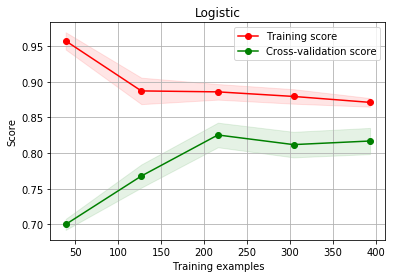

In [42]:
kfold = StratifiedKFold(n_splits=5)
g = plot_learning_curve(logrmodel,"Logistic",X_trainmodel_std,y_trainmodel.values.ravel(),cv=None)


In [43]:
from sklearn.model_selection import GridSearchCV
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 8, 10)
solver =['liblinear']
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty,solver=solver)
logistic = LogisticRegression()
grid_search = GridSearchCV(logistic, hyperparameters, cv=10, scoring="accuracy", verbose = 1,n_jobs =-1)
grid_search.fit(X_trainmodel_std,y_trainmodel.values.ravel())

grid_search_best = grid_search.best_estimator_

 #Best score
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))


Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s


Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.85
Best estimator:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.0s finished


Accuracy: 86.610
Classification report
             precision    recall  f1-score   support

          0       0.79      0.85      0.82       170
          1       0.76      0.69      0.72       121

avg / total       0.78      0.78      0.78       291

Confusion matrix
[[144  26]
 [ 38  83]]


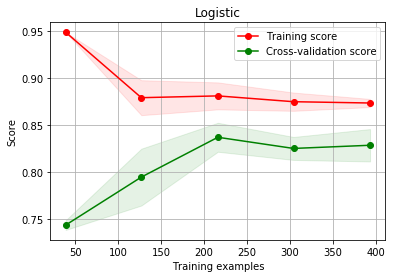

In [44]:

logrmodel = grid_search_best 

logrmodel.fit(X_trainmodel_std, y_trainmodel.values.ravel())
kfold = StratifiedKFold(n_splits=10)
g = plot_learning_curve(logrmodel,"Logistic",X_trainmodel_std,y_trainmodel.values.ravel(),cv=None)
result = logrmodel.score(X_trainmodel_std, y_trainmodel.values)
print ("Accuracy: {0:.3f}".format(result*100.0))
y_pred=measure_performance(X_val_std,y_val,logrmodel, show_accuracy=False, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)

y_pred_result=logrmodel.predict(test_dataset_std)

In [45]:
#0.61802902979373567608861726508785
#0.38197097020626432391138273491215
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
## Search grid for optimal parameters
from sklearn.ensemble import RandomForestClassifier
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1,7,10],
              "bootstrap": [False],
              "n_estimators" :[200],
              "criterion": ["gini"]
              #,"class_weight":[ {0:0.618,1:0.382}]
                }
rfc =RandomForestClassifier()
grid_search = GridSearchCV(rfc,param_grid = rf_param_grid, cv=10, scoring="accuracy", verbose = 1,n_jobs =-1)

grid_search.fit(X_trainmodel,y_trainmodel.values.ravel())

rfc_best = grid_search.best_estimator_

 #Best score
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  1.0min finished


Best parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.85
Best estimator:
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [46]:
rfc_best_params =grid_search.best_params_
#class_weight={0: 0.69, 1: 0.31} best 
#rfc =RandomForestClassifier(**rfc_best_params)
'''
rfc = RandomForestClassifier(bootstrap=False, class_weight={0: 0.66, 1: 0.34},
            criterion='gini', max_depth=None, max_features=76,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=10, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
            
rfc = RandomForestClassifier(bootstrap=False, class_weight={0: 0.70, 1: 0.30},
            criterion='gini', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=10, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)             

rfcbest = RandomForestClassifier(bootstrap=False, class_weight={0: 0.62, 1: 0.38},
            criterion='gini', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=10, min_samples_split=5 ,
            min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
            
'''
rfc = rfc_best

rfc.fit(X_trainmodel, y_trainmodel.values.ravel())
#g = plot_learning_curve(rfc,"RandomForest",X_trainmodel,y_trainmodel.values.ravel(),cv=None)
result = rfc.score(X_trainmodel, y_trainmodel.values)
print ("Accuracy: {0:.3f}".format(result*100.0))
y_pred=measure_performance(X_val,y_val,rfc, show_accuracy=False, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)

 
y_pred_result=rfc.predict(test_dataset)

Accuracy: 85.593
Classification report
             precision    recall  f1-score   support

          0       0.79      0.86      0.83       170
          1       0.78      0.69      0.73       121

avg / total       0.79      0.79      0.79       291

Confusion matrix
[[147  23]
 [ 38  83]]


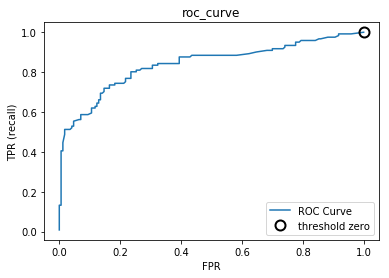

In [47]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, rfc.predict_proba(X_val)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("roc_curve");
# find threshold closest to zero:
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

In [48]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
#class_weight={0:0.618,1:0.382}
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_trainmodel, y_trainmodel.values.ravel())

ada_best = gsadaDTC.best_estimator_
print(ada_best)
 

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    5.6s


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random'),
          learning_rate=0.001, n_estimators=2, random_state=7)


[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:   11.7s finished


In [49]:
def plot_roc(y_val,model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve");
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)

Accuracy: 85.932
Classification report
             precision    recall  f1-score   support

          0       0.79      0.85      0.82       170
          1       0.77      0.69      0.72       121

avg / total       0.78      0.78      0.78       291

Confusion matrix
[[145  25]
 [ 38  83]]


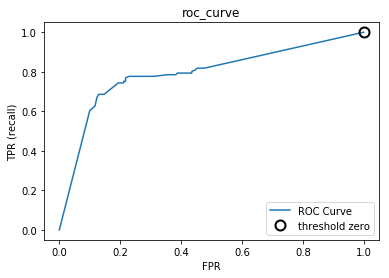

In [50]:
adaDTC =ada_best 

adaDTC.fit(X_trainmodel, y_trainmodel.values.ravel())
#g = plot_learning_curve(rfc,"RandomForest",X_trainmodel,y_trainmodel.values.ravel(),cv=None)
result = adaDTC.score(X_trainmodel_std, y_trainmodel.values)
print ("Accuracy: {0:.3f}".format(result*100.0))
y_pred=measure_performance(X_val,y_val,adaDTC, show_accuracy=False, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)
plot_roc(y_val,adaDTC)

In [74]:
extc = ExtraTreesClassifier()
#class_weight={0: 0.618, 1: 0.382}

## Search grid for optimal parameters
ex_param_grid = {"max_depth": [5],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini","entropy"]}


gsextc  = GridSearchCV(extc ,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsextc.fit(X_trainmodel, y_trainmodel.values.ravel())

extc_best = gsextc.best_estimator_

# Best score
gsextc.best_score_

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   42.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 1080 out of 1080 | elapsed:  4.0min finished


0.8542372881355932

Accuracy: 85.593
Classification report
             precision    recall  f1-score   support

          0       0.79      0.86      0.82       170
          1       0.78      0.67      0.72       121

avg / total       0.78      0.78      0.78       291

Confusion matrix
[[147  23]
 [ 40  81]]


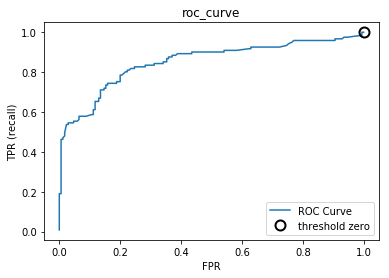

In [75]:
extc= extc_best

extc.fit(X_trainmodel, y_trainmodel.values.ravel())
#g = plot_learning_curve(rfc,"RandomForest",X_trainmodel,y_trainmodel.values.ravel(),cv=None)
result = extc.score(X_trainmodel_std, y_trainmodel.values)
print ("Accuracy: {0:.3f}".format(result*100.0))
y_pred=measure_performance(X_val,y_val,extc, show_accuracy=False, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)
plot_roc(y_val,extc)

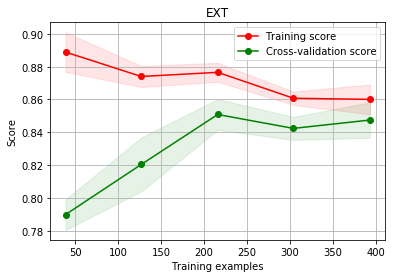

In [76]:
g = plot_learning_curve(extc,"EXT",X_trainmodel_std,y_trainmodel.values.ravel(),cv=None)

In [67]:
# Gradient boosting tunning

gbc = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [3,5,7],
              'max_features': [6,8],
              
              }

gsgbc = GridSearchCV(gbc,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsgbc.fit(X_trainmodel, y_trainmodel.values.ravel())

gbc_best = gsgbc.best_estimator_

# Best score
gsgbc.best_score_

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.0s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:   30.7s finished


0.8542372881355932

In [68]:
print(gbc_best )

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=6, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=7, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


Accuracy: 86.271
Classification report
             precision    recall  f1-score   support

          0       0.79      0.86      0.83       170
          1       0.78      0.68      0.73       121

avg / total       0.79      0.79      0.78       291

Confusion matrix
[[147  23]
 [ 39  82]]


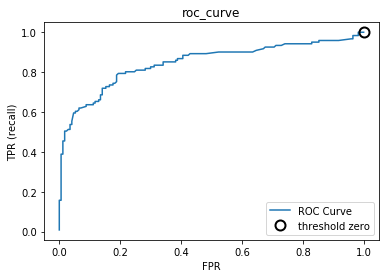

In [69]:
gbc=gbc_best
gbc.fit(X_trainmodel, y_trainmodel.values.ravel())
#g = plot_learning_curve(rfc,"RandomForest",X_trainmodel,y_trainmodel.values.ravel(),cv=None)
result = gbc.score(X_trainmodel_std, y_trainmodel.values)
print ("Accuracy: {0:.3f}".format(result*100.0))
y_pred=measure_performance(X_val,y_val,gbc, show_accuracy=False, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)
plot_roc(y_val,gbc)

In [70]:
y_pred=measure_performance(X_val_std,y_val,gbc, show_accuracy=False, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)

Classification report
             precision    recall  f1-score   support

          0       0.79      0.86      0.82       170
          1       0.78      0.67      0.72       121

avg / total       0.78      0.78      0.78       291

Confusion matrix
[[147  23]
 [ 40  81]]


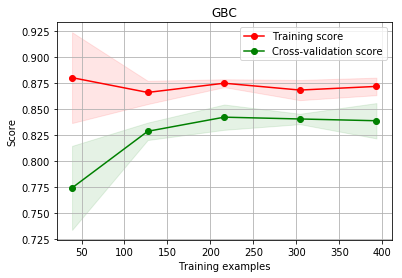

In [71]:
g = plot_learning_curve(gbc_best,"GBC",X_trainmodel_std,y_trainmodel.values.ravel(),cv=None)

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 90.339
Classification report
             precision    recall  f1-score   support

          0       0.79      0.88      0.83       170
          1       0.80      0.67      0.73       121

avg / total       0.79      0.79      0.79       291

Confusion matrix
[[150  20]
 [ 40  81]]


D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


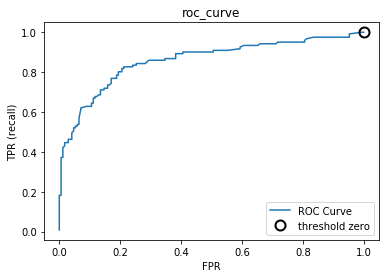

In [78]:
## Voting classifier
titanic_vc = VotingClassifier(estimators=[('rfc', rfc_best), ('extc', extc_best),
                                          ('adac',ada_best),('gbc',gbc_best)], voting='soft', n_jobs=4)
titanic_vc.fit(X_trainmodel, y_trainmodel.values.ravel())
#g = plot_learning_curve(rfc,"RandomForest",X_trainmodel,y_trainmodel.values.ravel(),cv=None)
result = titanic_vc.score(X_trainmodel, y_trainmodel.values)
print ("Accuracy: {0:.3f}".format(result*100.0))
y_pred=measure_performance(X_val,y_val,titanic_vc, show_accuracy=False, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)
plot_roc(y_val,titanic_vc)
y_pred_result=titanic_vc.predict(test_dataset)

In [79]:
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="submission_vcbest"+timestamp+"_out.csv"
submission = pd.DataFrame({
        "PassengerId": test_X["PassengerId"],
        "Survived": y_pred_result
    })
submission.to_csv(filename, index=False)

In [80]:
print(rfc_best.feature_importances_)

[1.4431e-02 2.3697e-02 8.4074e-03 1.8583e-02 3.3711e-02 8.3783e-03
 3.9410e-02 0.0000e+00 0.0000e+00 1.0822e-03 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 1.6269e-04 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 6.6782e-04 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 2.4370e-03 3.8156e-03 2.0465e-01 1.7877e-01 1.6312e-03 3.2551e-04
 2.7932e-03 9.7722e-04 5.0971e-03 1.7816e-03 0.0000e+00 0.0000e+00
 0.0000e+00 4.8077e-02 7.4966e-03 1.8934e-03 7.4169e-03 1.2296e-01
 1.9441e-01 2.7601e-03 3.0114e-03 2.0919e-03 1.2413e-02 7.3705e-03
 8.0900e-03 3.1207e-02]


"\nplt.title('Feature Importances')\n\nax.set_xticklabels(ax.get_xticklabels(),ha='right')\nplt.barh(range(len(indices)), importances[indices],  align='center',ax=ax)\nplt.yticks(range(len(indices)), features[indices])\nplt.xlabel('Relative Importance')\n"

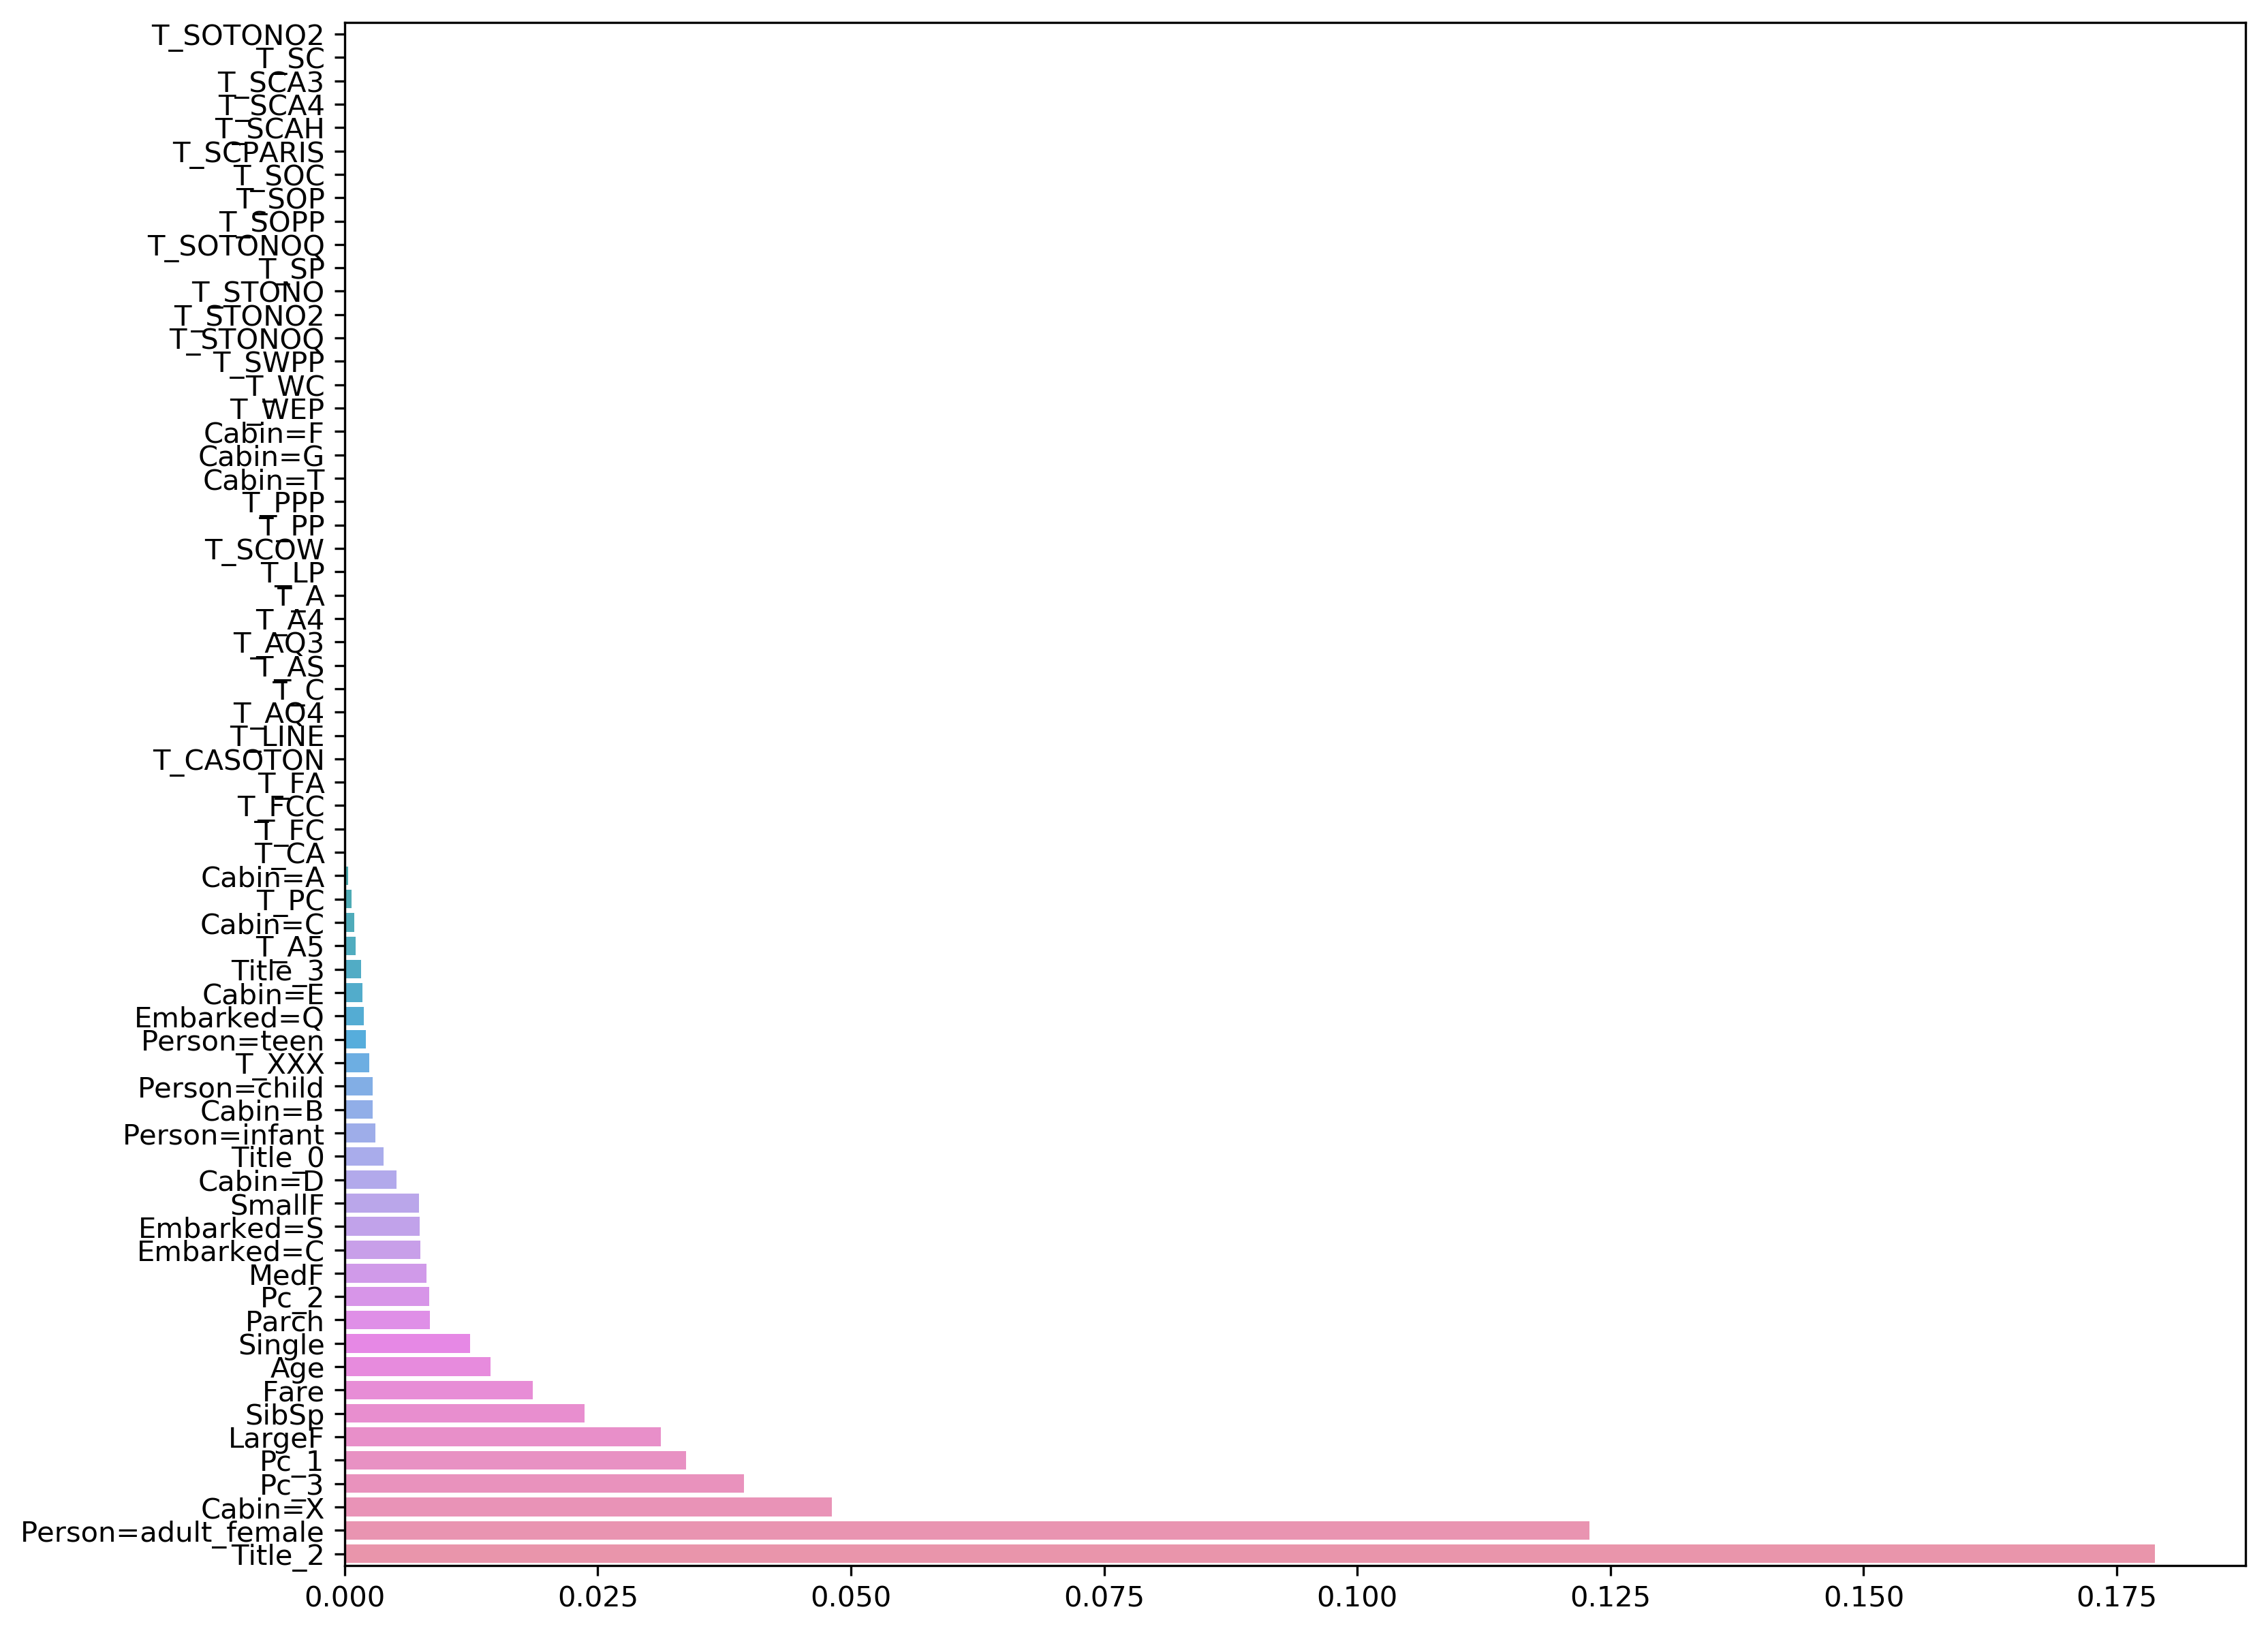

In [61]:
features = train_dataset.columns 
importances = rfc_best.feature_importances_
indices = np.argsort(importances)
fig = plt.figure(figsize=(12,10),dpi=300)
ax = fig.gca()
g = sns.barplot(y=features[indices][:66],x = importances[indices][:66] , orient='h')
#feature_imp =pd.DataFrame(data=importances[indices], columns=features[indices])
'''
plt.title('Feature Importances')

ax.set_xticklabels(ax.get_xticklabels(),ha='right')
plt.barh(range(len(indices)), importances[indices],  align='center',ax=ax)
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
'''

#plt.show()